# **Kaggle Competition : Toxic comment classification**

Team : Nishtha KHURANA, Irene SUNNY 

Problem Statement:
We are given a dataset with comments from online platform. We have the challenge of classifying the comments as toxic(1) or non-toxic(0). 





## **Exploratory Data Analysis**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toxic-comment/train_y.csv
/kaggle/input/toxic-comment/train_x.csv
/kaggle/input/toxic-comment/test_x.csv
/kaggle/input/toxic-comment/val_x.csv
/kaggle/input/toxic-comment/val_y.csv


## **Importing necessary files and libraries**

In [2]:
import os
import csv
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
#from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torchmetrics import AUROC, F1Score

In [3]:
import pandas as pd
import os

data_dir = 'kaggle/'

train_x = pd.read_csv('/kaggle/input/toxic-comment/train_x.csv', index_col=0)
test_x = pd.read_csv('/kaggle/input/toxic-comment/test_x.csv', index_col=0)
train_y = pd.read_csv('/kaggle/input/toxic-comment/train_y.csv')
val_x = pd.read_csv('/kaggle/input/toxic-comment/val_x.csv', index_col=0)
val_y = pd.read_csv('/kaggle/input/toxic-comment/val_y.csv')


## **Cleaning the data**

In [4]:
train_x['string'] = train_x['string'].str.lower()
test_x['string'] = test_x['string'].str.lower()
val_x['string'] = val_x['string'].str.lower()

In [5]:
# Print columns with the number of missing values
missing_values = train_x.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])


Columns with missing values:
string    1
dtype: int64


In [6]:
null_rows_specific_column = train_x[train_x['string'].isnull()]
print(null_rows_specific_column)
print(train_x[train_x['string'].isnull()].index)
null_indices=train_x[train_x['string'].isnull()].index

       string
index        
141037    NaN
Index([141037], dtype='int64', name='index')


In [7]:
train_x=train_x.drop(null_indices)
train_y = train_y.drop(null_indices)

# Reset index after dropping the rows
train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)

## **Exploring the datasets train_x and train_y**

In [8]:
print(train_x.info())
print(train_y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269037 entries, 0 to 269036
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   string  269037 non-null  object
dtypes: object(1)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269037 entries, 0 to 269036
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   male                269037 non-null  int64
 1   female              269037 non-null  int64
 2   LGBTQ               269037 non-null  int64
 3   christian           269037 non-null  int64
 4   muslim              269037 non-null  int64
 5   other_religions     269037 non-null  int64
 6   black               269037 non-null  int64
 7   white               269037 non-null  int64
 8   identity_any        269037 non-null  int64
 9   severe_toxicity     269037 non-null  int64
 10  obscene             269037 non-null  int64

## **Analyzing the distribution of target variable w.r.t demographic columns**

In [9]:
import pandas as pd
demographic_columns = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

value_counts_per_demographic = {}
df=train_y.copy()
for demographic in demographic_columns:
    filtered_df = df[df[demographic] == 1]
    value_counts_per_demographic[demographic] = filtered_df['y'].value_counts()

value_counts_df = pd.DataFrame(value_counts_per_demographic)

print(value_counts_df)


    male  female  LGBTQ  christian  muslim  other_religions  black  white
y                                                                        
0  25373   31282   6155      24292   10829             5541   6785  12016
1   4437    4962   2265       2446    3125             1003   3111   4682


## **Analyzing the relationship between target variable and toxicity columns**


In [10]:
toxic_columns=['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']
df=train_y[toxic_columns +['y']]

In [11]:
df1=df.copy()
df1.head()

,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y
0,0,0,0,0,1,0,1
1,0,0,0,0,1,0,1
2,0,0,0,1,0,0,1
3,0,0,0,0,1,0,1
4,0,0,0,1,0,0,1


In [12]:
count_y_and_severe_toxicity = len(df[(df['y'] == 1) & (df['severe_toxicity'] == 1)])
print('count_y_and_severe_toxicity',count_y_and_severe_toxicity)

count_severe_toxicity = len(df[df['severe_toxicity'] == 1])
print('count_severe_toxicity',count_severe_toxicity)

probability = count_y_and_severe_toxicity / count_severe_toxicity

print(f"P(y=1 | 'severe_toxicity'=1) = {probability:.2f}")

count_y_and_severe_toxicity 7
count_severe_toxicity 7
P(y=1 | 'severe_toxicity'=1) = 1.00


In [13]:
count_y_and_obscene_toxicity = len(df[(df['y'] == 1) & (df['obscene'] == 1)])
print('count_y_and_obscene_toxicity',count_y_and_obscene_toxicity)

count_obscene_toxicity = len(df[df['obscene'] == 1])
print('count_obscene_toxicity',count_obscene_toxicity)
probability = count_y_and_obscene_toxicity / count_obscene_toxicity

print(f"P(y=1 | 'obscene'=1) = {probability:.2f}")

count_y_and_obscene_toxicity 1651
count_obscene_toxicity 1683
P(y=1 | 'obscene'=1) = 0.98


In [14]:
count_y_and_threat = len(df[(df['y'] == 1) & (df['threat'] == 1)])
print('count_y_and_threat',count_y_and_threat)

count_threat = len(df[df['threat'] == 1])
print('count_threat',count_threat)

probability = count_y_and_threat / count_threat

print(f"P(y=1 | 'threat'=1) = {probability:.2f}")

count_y_and_threat 646
count_threat 659
P(y=1 | 'threat'=1) = 0.98


## **Plotting the correlation matrix**

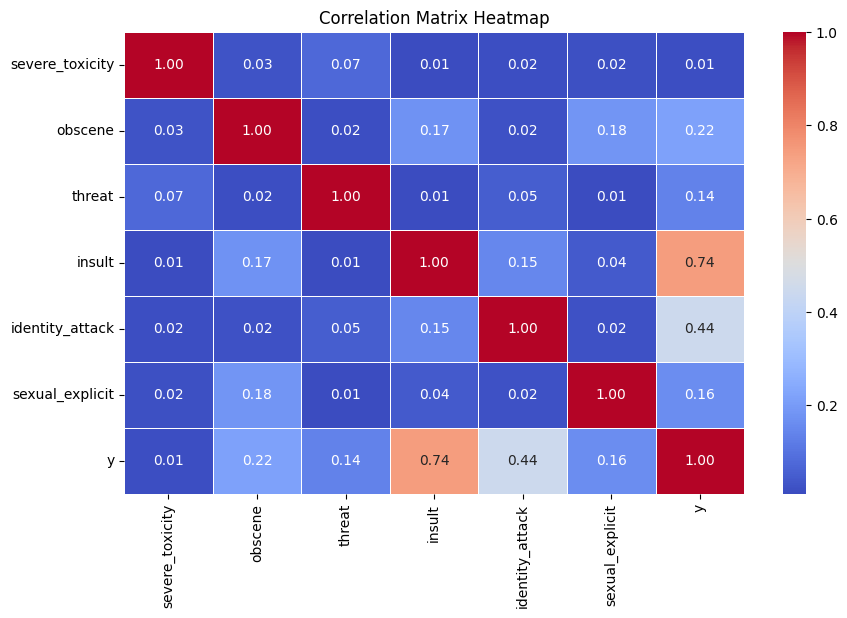

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[toxic_columns+['y']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

/tmp/ipykernel_43/1020188227.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_col'] = df[toxic_columns].any(axis=1).astype(int)


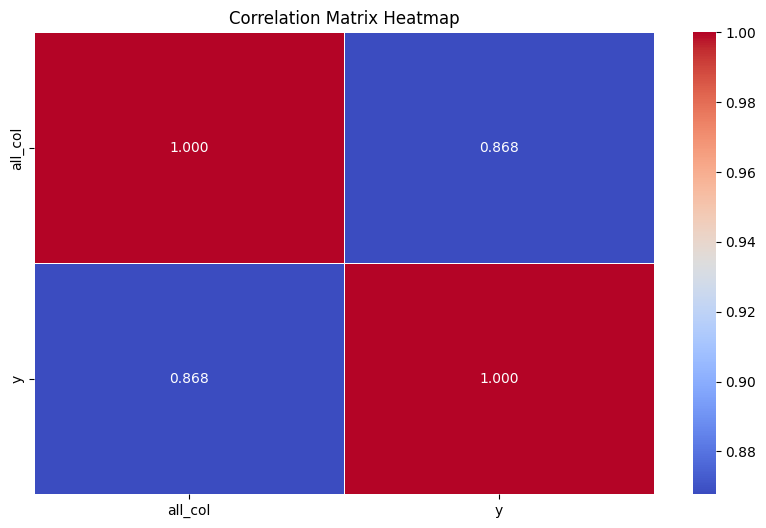

In [16]:
#all_col signifies that if any of the toxicity columns are 1, then this will be 1. 
#We get a correlation of 0.86 between all_col and target variable which is very high 

df['all_col'] = df[toxic_columns].any(axis=1).astype(int)
correlation_matrix = df[['all_col','y']].corr()
                   
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Filtering the rows for demographic columns when present to analyze the correlation between toxicity and target variable

In [17]:
categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
filtered_rows = train_y[categories].any(axis=1)
df_cat = train_y.loc[filtered_rows, toxic_columns+['y']]

correlation_matrix = df_cat[toxic_columns+['y']].corr()

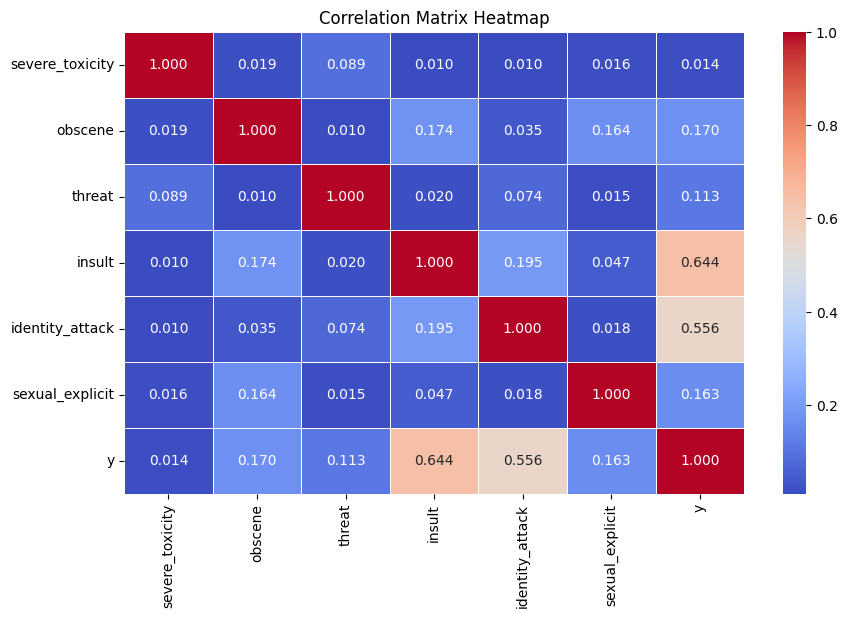

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Analyzing source domain variable

In [19]:
#We observe that there is only 1 value in source domain, therefore this feature is not providing us 
# any information 
unique_values = train_y['from_source_domain'].unique()
print(unique_values)
print(train_y['from_source_domain'].value_counts())

[1]
from_source_domain
1    269037
Name: count, dtype: int64


In [20]:
#Description of train_y data
train_y.describe()

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
count,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.000000,269037.0
mean,0.110803,0.134718,0.031297,0.099384,0.051866,0.024324,0.036783,0.062066,0.421764,0.000026,0.006256,0.002449,0.068663,0.029000,0.005007,0.113423,1.0
std,0.313888,0.341422,0.174119,0.299178,0.221758,0.154053,0.188229,0.241275,0.493842,0.005101,0.078845,0.049432,0.252881,0.167806,0.070581,0.317110,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


## Distribution of target variable 'y' for the demographic columns

We can see that there is huge class imbalance when the identity is present or not in the demographic columns

In [21]:
print(train_y['y'].value_counts(normalize=True))

for column in demographic_columns:
    print(f"{column} distribution:\n{train_y[column].value_counts(normalize=True)}\n")


y
0    0.886577
1    0.113423
Name: proportion, dtype: float64
male distribution:
male
0    0.889197
1    0.110803
Name: proportion, dtype: float64

female distribution:
female
0    0.865282
1    0.134718
Name: proportion, dtype: float64

LGBTQ distribution:
LGBTQ
0    0.968703
1    0.031297
Name: proportion, dtype: float64

christian distribution:
christian
0    0.900616
1    0.099384
Name: proportion, dtype: float64

muslim distribution:
muslim
0    0.948134
1    0.051866
Name: proportion, dtype: float64

other_religions distribution:
other_religions
0    0.975676
1    0.024324
Name: proportion, dtype: float64

black distribution:
black
0    0.963217
1    0.036783
Name: proportion, dtype: float64

white distribution:
white
0    0.937934
1    0.062066
Name: proportion, dtype: float64



## **Distribution of length of comment**

## Training data

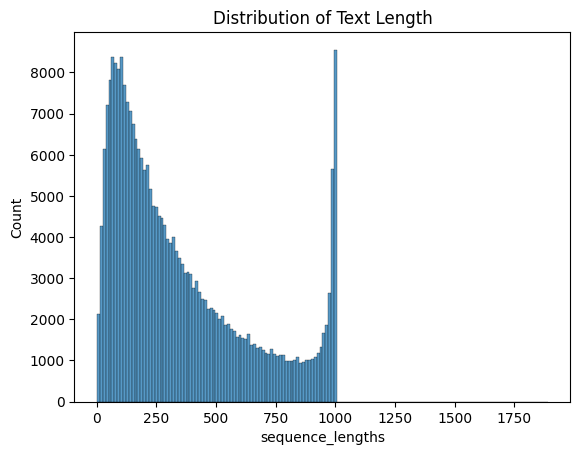

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
train_x['sequence_lengths'] = train_x['string'].apply(len)
sns.histplot(train_x['sequence_lengths'])
plt.title('Distribution of Text Length')
plt.show()


## Testing data

In [24]:
test_x['string']=test_x['string'].fillna('')

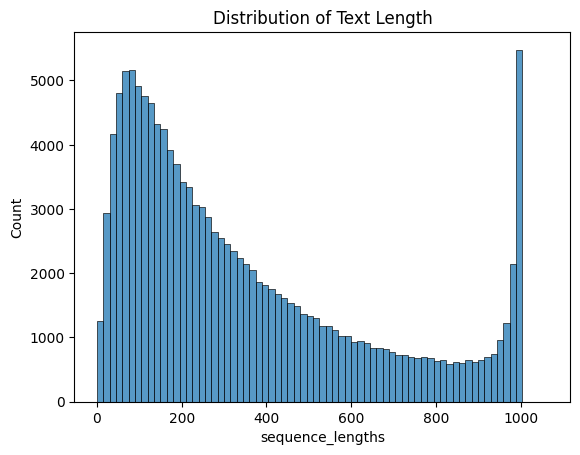

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
test_x['sequence_lengths'] = test_x['string'].apply(len)
sns.histplot(test_x['sequence_lengths'])
plt.title('Distribution of Text Length')
plt.show()


In [26]:
#Analysis of longer texts (2nd peak)
long_threshold = 990
short_threshold = 250

med_comments = train_x[(train_x['sequence_lengths'] >= short_threshold) & (train_x['sequence_lengths'] <= long_threshold)]
long_comments = train_x[train_x['sequence_lengths'] > long_threshold]
short_comments = train_x[train_x['sequence_lengths'] < short_threshold]

In [27]:
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# Then, load the English stop words list
stop_words = set(stopwords.words('english'))

# Download the punkt tokenizer for sentence splitting
nltk.download('punkt')

# Tokenize the comments and count the word frequencies
words_short = word_tokenize(' '.join(short_comments['string'].values))
words_med = word_tokenize(' '.join(med_comments['string'].values))
words_long = word_tokenize(' '.join(long_comments['string'].values))

filtered_words_short = [word for word in words_short if word.lower() not in stop_words and word.isalnum()]
filtered_words_med = [word for word in words_med if word.lower() not in stop_words and word.isalnum()]
filtered_words_long = [word for word in words_long if word.lower() not in stop_words and word.isalnum()]

# Count the frequency of the remaining words
word_freq_short = Counter(filtered_words_short)
word_freq_med = Counter(filtered_words_med)
word_freq_long = Counter(filtered_words_long)

# Get the 20 most common words
common_words_short = word_freq_short.most_common(20)
common_words_med = word_freq_med.most_common(20)
common_words_long = word_freq_long.most_common(20)



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Word cloud for the common words

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


### Word cloud for short comments

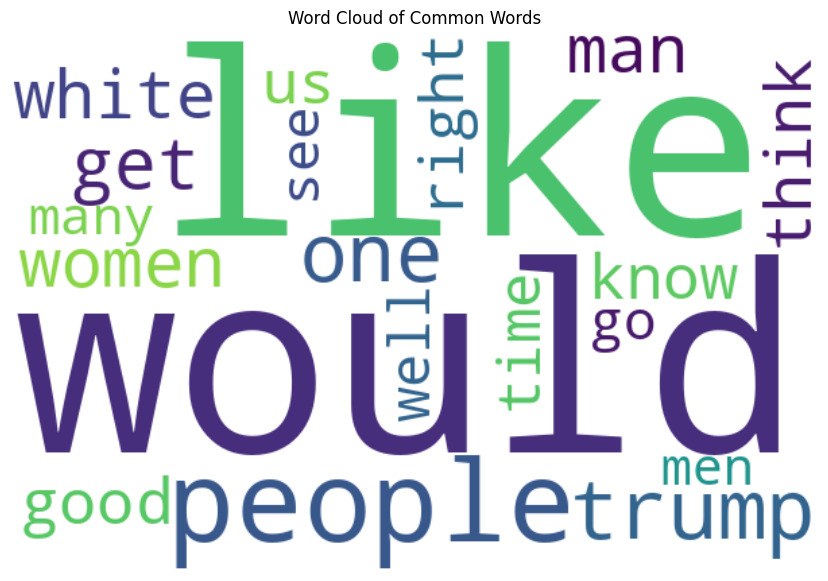

In [29]:

wordcloud_data = dict(common_words_short)

wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Common Words')
plt.show()

### Word cloud for medium length comments

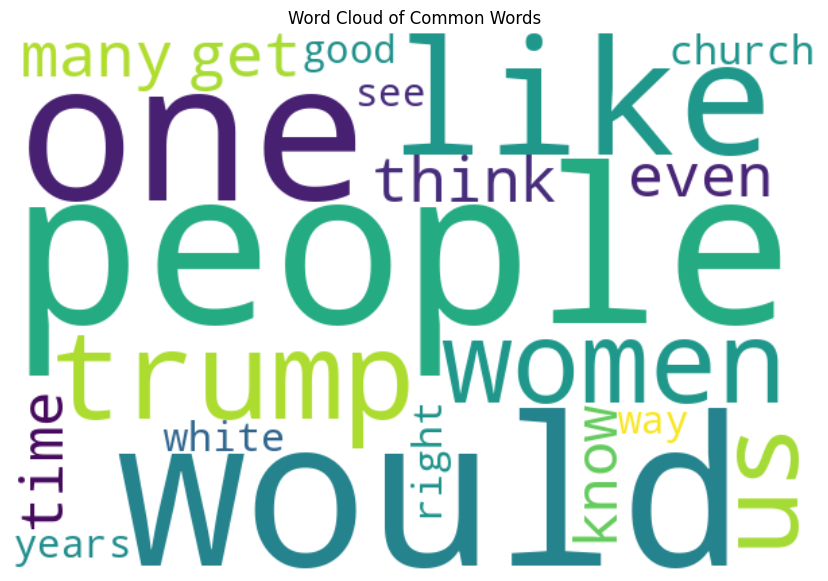

In [30]:
wordcloud_data = dict(common_words_med)

wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Common Words')
plt.show()


### Word cloud for longer length comments

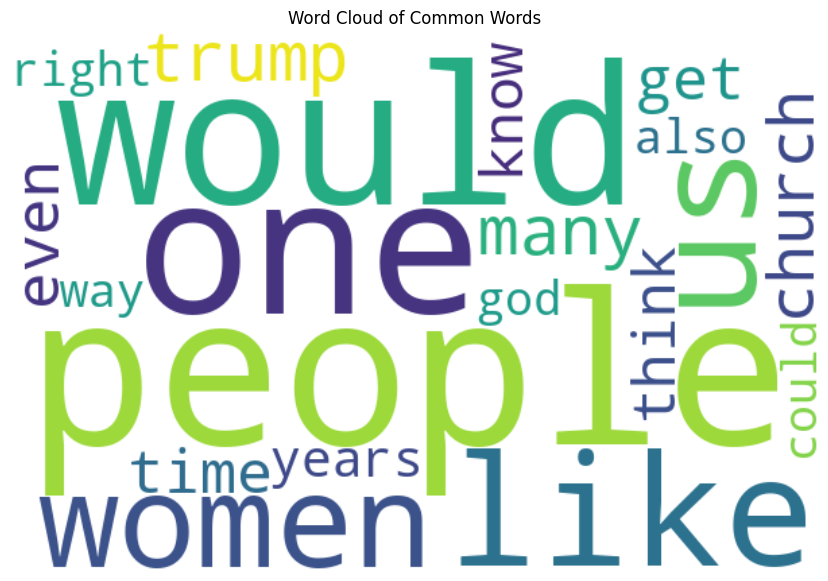

In [31]:
wordcloud_data = dict(common_words_long)

wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Common Words')
plt.show()


### Word cloud for the entire dataset

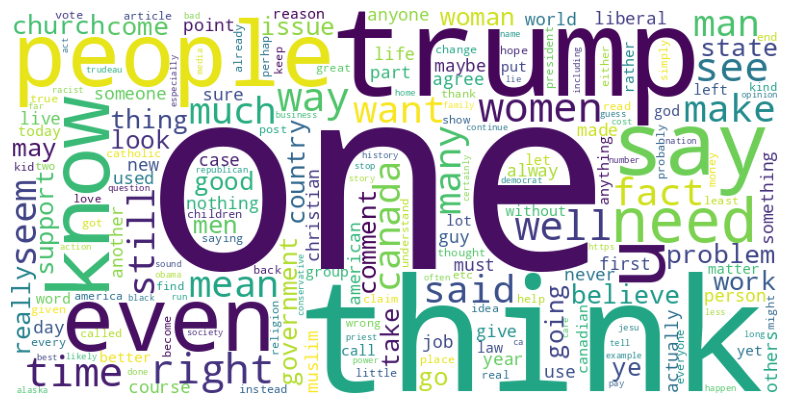

In [32]:
words = word_tokenize(' '.join(train_x['string'].values))

# Remove stop words and non-alphanumeric characters from the list of words
filtered_words = [word for word in words if word.lower() not in stop_words and word.isalnum()]

# Generate the word cloud data from the filtered list of words
wordcloud_data = ' '.join(filtered_words)

# text_data = ' '.join(train_x['string'].values)
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**We analysed this as we plan to implement BERT model which does not work well for very long sequences**


As from the result below, 95 percentile of our data has less than 165 as sequence length. Therefore we can use BERT efficiently for modeling. 

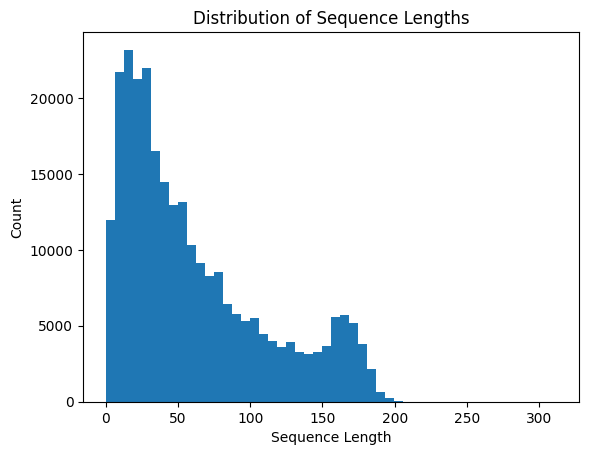

In [33]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x['string'])  # train_x['string'] should be the column with text data
tokenized_sequences = tokenizer.texts_to_sequences(train_x['string'])

seq_length_for_BERT = [len(seq) for seq in tokenized_sequences]
import matplotlib.pyplot as plt

plt.hist(seq_length_for_BERT, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [34]:
import numpy as np
max_sequence_length = np.percentile(seq_length_for_BERT, 95)
print(f"95% of the sequences have length <= {max_sequence_length}")


95% of the sequences have length <= 167.0
